In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sys
import h5py

# shouldn't need this if have illustris_python properly in python path! todo: check if fixed upon reload
sys.path.insert(1, '/home/ksf293/external')
import illustris_python as il

In [2]:
tng_path = '/scratch/ksf293/gnn-cosmology/data/TNG50-4'
tng_path_dark = '/scratch/ksf293/gnn-cosmology/data/TNG50-4-Dark'
base_path = '/scratch/ksf293/gnn-cosmology/data/TNG50-4/output'
base_path_dark = '/scratch/ksf293/gnn-cosmology/data/TNG50-4-Dark/output'
snap_num = 99

Load in dark and full sims

In [3]:
fields = ['SubhaloMass','SubhaloPos','SubhaloMassType', 'SubhaloHalfmassRad']

subhalos = il.groupcat.loadSubhalos(base_path,snap_num,fields=fields)
halos = il.groupcat.loadHalos(base_path,snap_num)

subhalos_dark = il.groupcat.loadSubhalos(base_path_dark,snap_num,fields=fields)
halos_dark = il.groupcat.loadHalos(base_path_dark,snap_num)

Load twin-matching file

In [4]:
f = h5py.File(f'{tng_path}/postprocessing/subhalo_matching_to_dark.hdf5','r')
# two different matching algorithms: 'SubhaloIndexDark_LHaloTree' & 'SubhaloIndexDark_SubLink'
full_to_dark_inds = f[f'Snapshot_{snap_num}']['SubhaloIndexDark_LHaloTree']

Build dicts to match subhalos both ways. If a full subhalo has no dark subhalo twin, exclude it.

In [5]:
full_to_dark_dict = {}
dark_to_full_dict = {}
for i in range(len(full_to_dark_inds)):
    idx_full = i
    idx_dark = full_to_dark_inds[idx_full]
    if idx_dark == -1:
        continue
    dark_to_full_dict[idx_dark] = idx_full
    full_to_dark_dict[idx_full] = idx_dark

Get most massive subhalo in each dark halo; then find that subhalo's twin in the full sim. If it doesn't have a twin (aka not in dict), exclude. Also, if there are no star particles in the matched subhalo in the full sim, exclude.

GroupFirstSub: Index into the Subhalo table of the first/primary/most massive Subfind group within this FoF group. Note: This value is signed (or should be interpreted as signed)! In this case, a value of -1 indicates that this FoF group has no subhalos.

In [6]:
halos_dark['GroupFirstSub'] = halos_dark['GroupFirstSub'].astype('int32')
w = np.where(halos_dark['GroupFirstSub'] >= 0) # filter out halos with no subhalos
epsilon = 1e-6

idxs_halos_all = np.array(list(range(halos_dark['count'])))[w]
idxs_firstsubs_dark_all = halos_dark['GroupFirstSub'][w]

idxs_halos = []
idxs_firstsub_dark = []
idxs_firstsub = []
for i, idx_halo in enumerate(idxs_halos_all):
    
    idx_firstsub_dark = idxs_firstsubs_dark_all[i]
    if idx_firstsub_dark in dark_to_full_dict:
        
        idx_firstsub = dark_to_full_dict[idx_firstsub_dark]
        # if no stars in subhalo, exclude
        if subhalos['SubhaloMassType'][:,4][idx_firstsub] < epsilon: 
            continue
                    
        idxs_halos.append(idx_halo)
        idxs_firstsub.append(idx_firstsub)
        idxs_firstsub_dark.append(idx_firstsub_dark)
        
# idxs_halos = np.array(list(range(halos_dark['count'])))[w]
# idxs_firstsub = halos_dark['GroupFirstSub'][w]
# idxs_firstsub_dark = full_to_dark_inds[idxs_firstsub]

Make arrays of all subhalos and their twins

In [7]:
# idxs_subhalos = np.array(list(range(subhalos['count'])))
# idxs_subhalos_dark_matched = full_to_dark_inds[idxs_subhalos]

Remove subhalos with no dark twins

In [8]:
# arg_clean = np.where(idxs_subhalos_dark_matched >= 0)[0]
# idxs_subhalos_clean = idxs_subhalos[arg_clean]
# idxs_subhalos_dark_matched_clean = idxs_subhalos_dark_matched[arg_clean]

Load up properties for halos/subhalos

In [9]:
pos = subhalos['SubhaloPos']
rad = subhalos['SubhaloHalfmassRad']
mass = subhalos['SubhaloMassType'][:,4] #4: star/wind particles

pos_dark = subhalos_dark['SubhaloPos']
rad_dark = subhalos_dark['SubhaloHalfmassRad']

pos_halo = halos_dark['GroupPos']
rad_halo = halos_dark['Group_R_Crit200']
mass_halo = halos_dark['GroupMass']

## All halos & subhalos

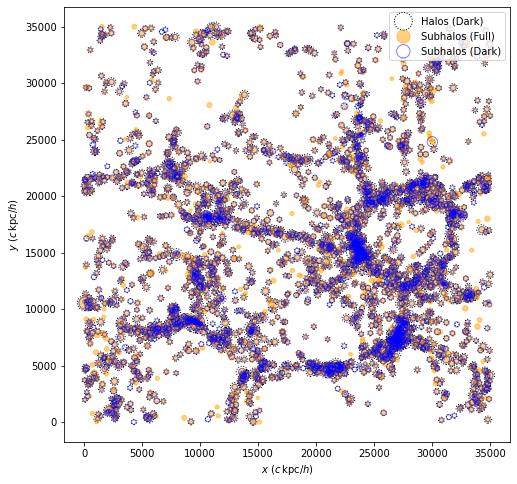

In [10]:
zslice = 0, 5000

idx_inzslice = np.where((zslice[0] < pos[:,2]) & (pos[:,2] < zslice[1]))
pos_inzslice = pos[idx_inzslice]
rad_inzslice = rad[idx_inzslice]
idx_dark_inzslice = np.where((zslice[0] < pos_dark[:,2]) & (pos_dark[:,2] < zslice[1]))
pos_dark_inzslice = pos_dark[idx_dark_inzslice]
rad_dark_inzslice = rad_dark[idx_dark_inzslice]
idx_halo_inzslice = np.where((zslice[0] < pos_halo[:,2]) & (pos_halo[:,2] < zslice[1]))
pos_halo_inzslice = pos_halo[idx_halo_inzslice]
rad_halo_inzslice = rad_halo[idx_halo_inzslice]

plt.figure(figsize=(8,8))
plt.scatter(pos_halo_inzslice[:,0], pos_halo_inzslice[:,1], s=rad_halo_inzslice,
            color='black', facecolors='none', alpha=1, ls=':', label='Halos (Dark)')
plt.scatter(pos_inzslice[:,0], pos_inzslice[:,1], s=rad_inzslice, 
            color='orange', alpha=0.5, label='Subhalos (Full)')
plt.scatter(pos_dark_inzslice[:,0], pos_dark_inzslice[:,1], s=rad_dark_inzslice,
            color='blue', facecolors='none', alpha=0.5, label='Subhalos (Dark)')

plt.xlabel(r'$x$ ($c\,$kpc/$h$)')
plt.ylabel(r'$y$ ($c\,$kpc/$h$)')
plt.legend()

### Zoom-in 

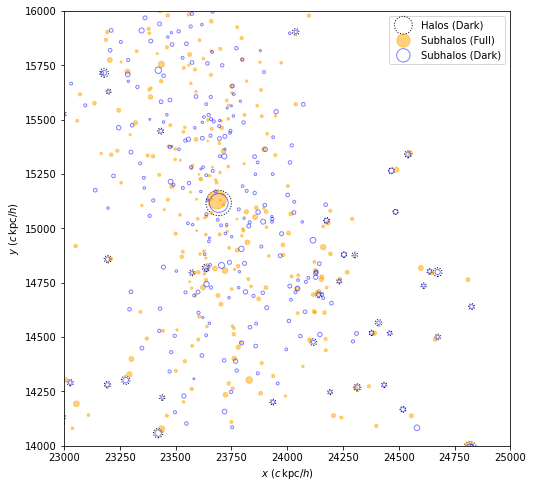

In [11]:
xlim = [23000,25000]
ylim = [14000,16000]

zslice = 0, 5000

idx_inzslice = np.where((zslice[0] < pos[:,2]) & (pos[:,2] < zslice[1]))
pos_inzslice = pos[idx_inzslice]
rad_inzslice = rad[idx_inzslice]
idx_dark_inzslice = np.where((zslice[0] < pos_dark[:,2]) & (pos_dark[:,2] < zslice[1]))
pos_dark_inzslice = pos_dark[idx_dark_inzslice]
rad_dark_inzslice = rad_dark[idx_dark_inzslice]
idx_halo_inzslice = np.where((zslice[0] < pos_halo[:,2]) & (pos_halo[:,2] < zslice[1]))
pos_halo_inzslice = pos_halo[idx_halo_inzslice]
rad_halo_inzslice = rad_halo[idx_halo_inzslice]

plt.figure(figsize=(8,8))
plt.scatter(pos_halo_inzslice[:,0], pos_halo_inzslice[:,1], s=rad_halo_inzslice,
            color='black', facecolors='none', alpha=1, ls=':', label='Halos (Dark)')
plt.scatter(pos_inzslice[:,0], pos_inzslice[:,1], s=rad_inzslice, 
            color='orange', alpha=0.5, label='Subhalos (Full)')
plt.scatter(pos_dark_inzslice[:,0], pos_dark_inzslice[:,1], s=rad_dark_inzslice,
            color='blue', facecolors='none', alpha=0.5, label='Subhalos (Dark)')

plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel(r'$x$ ($c\,$kpc/$h$)')
plt.ylabel(r'$y$ ($c\,$kpc/$h$)')
plt.legend()

## Halos (dark) w/ subhalos only, w/ their most massive dark subhalo, & its full-sim twin

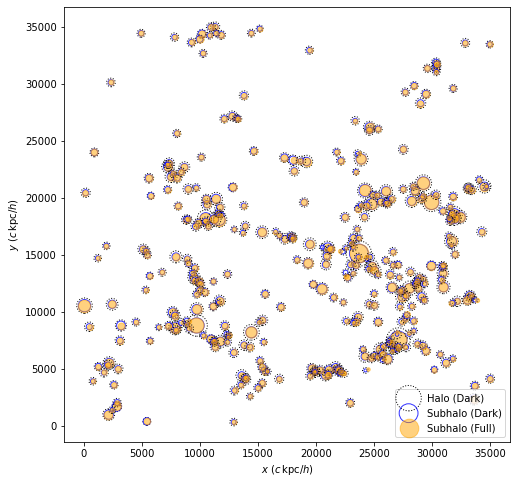

In [12]:
nlocs = len(idxs_halos)
loc_min = 0
loc_max = nlocs
locs = np.linspace(loc_min, loc_max, nlocs)
locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
cmap = matplotlib.cm.get_cmap('rainbow')

plt.figure(figsize=(8,8))

first = True
for i, idx_halo in enumerate(idxs_halos):

    idx_sub = idxs_firstsub[i]
    idx_sub_dark = idxs_firstsub_dark[i]
    
    rad_i = rad[idx_sub]
    rad_dark_i = rad_dark[idx_sub_dark]
    rad_halo_i = rad_halo[idx_halo]

    pos_i = pos[idx_sub]
    pos_dark_i = pos_dark[idx_sub_dark] 
    pos_halo_i = pos_halo[idx_halo]
    
    if pos_i[2] < zslice[0] or pos_i[2] > zslice[1] \
        or pos_dark_i[2] < zslice[0] or pos_dark_i[2] > zslice[1] \
        or pos_halo_i[2] < zslice[0] or pos_halo_i[2] > zslice[1]:    
        continue

    color = cmap(locs_norm(idx_halo))
    
    label, label_dark, label_halo = None, None, None
    if first:
        label = 'Subhalo (Full)'
        label_dark = 'Subhalo (Dark)'
        label_halo = 'Halo (Dark)'
        first = False
    
    plt.scatter(pos_halo_i[0], pos_halo_i[1], s=rad_halo_i, label=label_halo,
                color='black', facecolors='none', alpha=1, ls=':')
    plt.scatter(pos_dark_i[0], pos_dark_i[1], s=rad_dark_i, label=label_dark,
                color='blue', facecolors='none', alpha=0.8)
    plt.scatter(pos_i[0], pos_i[1], s=rad_i, label=label, 
                color='orange', alpha=0.5)

plt.xlabel(r'$x$ ($c\,$kpc/$h$)')
plt.ylabel(r'$y$ ($c\,$kpc/$h$)')
plt.legend()

### Color-coded by twin & parent association

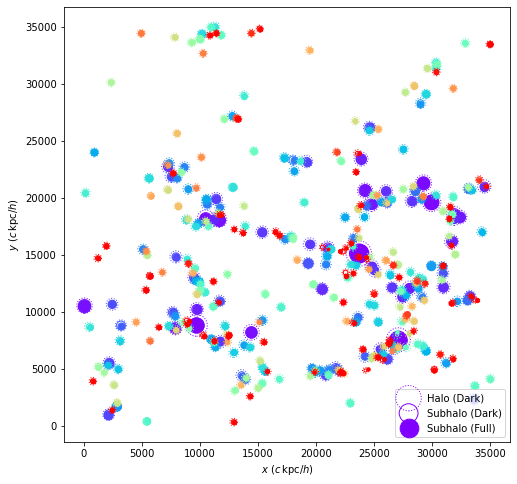

In [13]:
nlocs = len(idxs_halos)
loc_min = 0
loc_max = nlocs
locs = np.linspace(loc_min, loc_max, nlocs)
locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
cmap = matplotlib.cm.get_cmap('rainbow')

plt.figure(figsize=(8,8))

first = True
for i, idx_halo in enumerate(idxs_halos):

    idx_sub = idxs_firstsub[i]
    idx_sub_dark = idxs_firstsub_dark[i]
    
    rad_i = rad[idx_sub]
    rad_dark_i = rad_dark[idx_sub_dark]
    rad_halo_i = rad_halo[idx_halo]

    pos_i = pos[idx_sub]
    pos_dark_i = pos_dark[idx_sub_dark] 
    pos_halo_i = pos_halo[idx_halo]
    
    if pos_i[2] < zslice[0] or pos_i[2] > zslice[1] \
        or pos_dark_i[2] < zslice[0] or pos_dark_i[2] > zslice[1] \
        or pos_halo_i[2] < zslice[0] or pos_halo_i[2] > zslice[1]:    
        continue

    color = cmap(locs_norm(idx_halo))
    
    label, label_dark, label_halo = None, None, None
    if first:
        label = 'Subhalo (Full)'
        label_dark = 'Subhalo (Dark)'
        label_halo = 'Halo (Dark)'
        first = False
    
    plt.scatter(pos_halo_i[0], pos_halo_i[1], s=rad_halo_i, label=label_halo,
                color=color, facecolors='none', alpha=1, ls=':')
    plt.scatter(pos_dark_i[0], pos_dark_i[1], s=rad_dark_i, label=label_dark,
                color=color, facecolors='none', alpha=1)
    plt.scatter(pos_i[0], pos_i[1], s=rad_i, label=label, 
                color=color, alpha=1)

plt.xlabel(r'$x$ ($c\,$kpc/$h$)')
plt.ylabel(r'$y$ ($c\,$kpc/$h$)')
plt.legend()

### Color-coded, zoom-in

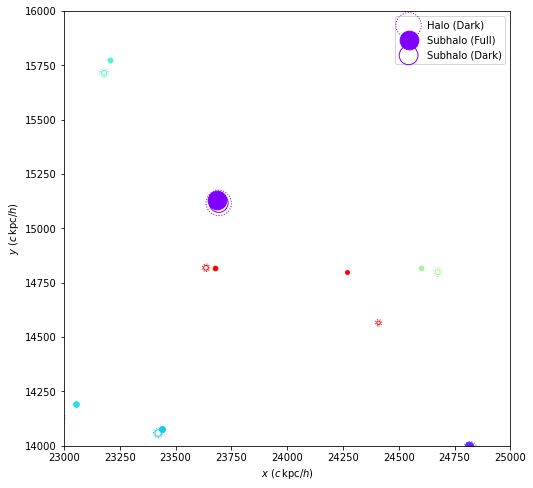

In [30]:
xlim = [23000,25000]
ylim = [14000,16000]

nlocs = len(idxs_halos)
loc_min = 0
loc_max = nlocs
locs = np.linspace(loc_min, loc_max, nlocs)
locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
cmap = matplotlib.cm.get_cmap('rainbow')

plt.figure(figsize=(8,8))

first = True
for i, idx_halo in enumerate(idxs_halos):

    idx_sub = idxs_firstsub[i]
    idx_sub_dark = idxs_firstsub_dark[i]
    
    rad_i = rad[idx_sub]
    rad_dark_i = rad_dark[idx_sub_dark]
    rad_halo_i = rad_halo[idx_halo]

    pos_i = pos[idx_sub]
    pos_dark_i = pos_dark[idx_sub_dark] 
    pos_halo_i = pos_halo[idx_halo]
        
    if pos_i[2] < zslice[0] or pos_i[2] > zslice[1] \
        or pos_dark_i[2] < zslice[0] or pos_dark_i[2] > zslice[1] \
        or pos_halo_i[2] < zslice[0] or pos_halo_i[2] > zslice[1]:    
        continue

    color = cmap(locs_norm(idx_halo))
    
    label, label_dark, label_halo = None, None, None
    if first:
        label = 'Subhalo (Full)'
        label_dark = 'Subhalo (Dark)'
        label_halo = 'Halo (Dark)'
        first = False
    
    plt.scatter(pos_halo_i[0], pos_halo_i[1], s=rad_halo_i, label=label_halo,
                color=color, facecolors='none', alpha=1, ls=':')
    plt.scatter(pos_i[0], pos_i[1], s=rad_i, label=label, 
                color=color, alpha=1)
    plt.scatter(pos_dark_i[0], pos_dark_i[1], s=rad_dark_i, label=label_dark,
                color=color, facecolors='none', alpha=1)

plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel(r'$x$ ($c\,$kpc/$h$)')
plt.ylabel(r'$y$ ($c\,$kpc/$h$)')
plt.legend()

# Inputs and outputs

In [15]:
n_halos = len(idxs_halos)
input_halo_dark = np.empty((n_halos, 4)) # 3 positions + 1 mass = 4
output_subhalo_stars = np.empty((n_halos, 4))

for i, idx_halo in enumerate(idxs_halos):

    idx_sub = idxs_firstsub[i]
    
    mass_i = mass[idx_sub]
    mass_halo_i = mass_halo[idx_halo]

    pos_i = pos[idx_sub]
    pos_halo_i = pos_halo[idx_halo]
    
    input_halo_dark[i,:3] = pos_halo_i
    input_halo_dark[i,3] = mass_halo_i
    
    output_subhalo_stars[i,:3] = pos_i
    output_subhalo_stars[i,3] = mass_i

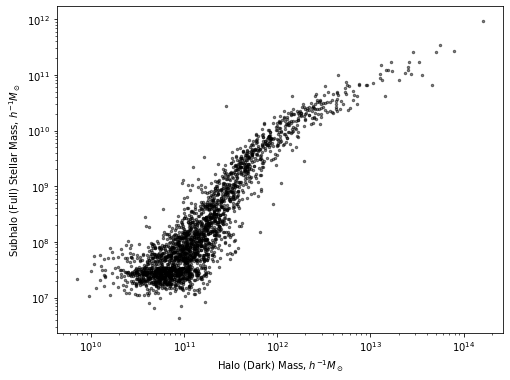

In [17]:
plt.figure(figsize=(8,6))
# *1e10 bc in units of 10^10 𝑀_⊙/ℎ
plt.scatter(input_halo_dark[:,3]*1e10, output_subhalo_stars[:,3]*1e10, s=6, alpha=0.5, c='k')
plt.xlabel(r"Halo (Dark) Mass, $h^{-1} M_\odot$")
plt.ylabel(r"Subhalo (Full) Stellar Mass, $h^{-1} M_\odot$")
plt.xscale('log')
plt.yscale('log')


Wrap distance differences around box:

In [27]:
L = 35000
delta_pos = input_halo_dark[:,:3] - output_subhalo_stars[:,:3]
for i in range(len(delta_pos)):
    if delta_pos[i][0] > L/2:
        delta_pos[i][0] = L - delta_pos[i][0]
    if delta_pos[i][1] > L/2:
        delta_pos[i][1] = L - delta_pos[i][1]
    if delta_pos[i][2] > L/2:
        delta_pos[i][2] = L - delta_pos[i][2]
delta_r = np.linalg.norm(delta_pos, axis=1)

Text(0, 0.5, 'count')

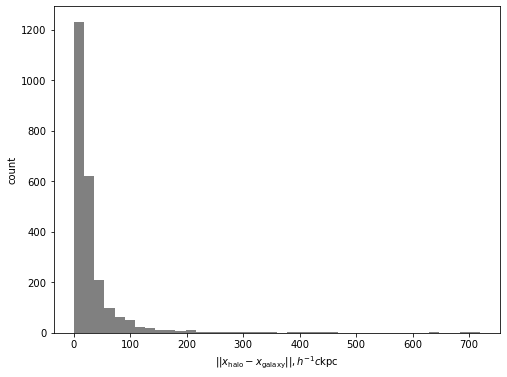

In [29]:
plt.figure(figsize=(8,6))
plt.hist(delta_r, bins=40, color='grey')
plt.xlabel(r'$|| x_\mathrm{halo} - x_\mathrm{galaxy} ||, h^{-1} c$kpc')
plt.ylabel("count")

In [33]:
# import sklearn
# from sklearn.neural_network import MLPRegressor

# model = MLPRegressor(random_state=1, max_iter=500)
# model.fit(input_halo_dark, output_subhalo_stars)
# model.predict(X_test[:2])